In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test_data.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

<br>
<br>
<br>

group, home planet, last_name

In [60]:
group = train_data.PassengerId.apply(lambda x: int(x.split("_")[0]))
last_name = train_data.Name.apply(lambda x: np.nan if pd.isna(x) else x.split(" ")[1])

In [61]:
group_last_name_home_planet = pd.DataFrame(data={'group': group, 'last_name': last_name, 'home_planet': train_data.HomePlanet})

group_last_name_home_planet.head()

,group,last_name,home_planet
0,1,Ofracculy,Europa
1,2,Vines,Earth
2,3,Susent,Europa
3,3,Susent,Europa
4,4,Santantines,Earth


In [62]:
group_last_name_home_planet.isna().sum()

group            0
last_name      200
home_planet    201
dtype: int64

In [69]:
group_last_name_home_planet.groupby('group').nunique().home_planet.value_counts()

1    6107
0     110
Name: home_planet, dtype: int64

In [70]:
group_last_name_home_planet.groupby('last_name').nunique().home_planet.value_counts()

1    2209
0       8
Name: home_planet, dtype: int64

note:
- passengers in each group, travel from same home planet
- passengers with same last name are from same planet

action:
- fill missing values in home planet using above two findings

In [71]:
group_home_planet_dict = {}
last_name_home_planet_dict = {}

def link_to_home_planet(x):
    if x.group not in group_home_planet_dict:
        if pd.notna(x.home_planet):
            group_home_planet_dict[x.group] = x.home_planet
    
    if pd.notna(x.last_name):
        if x.last_name not in last_name_home_planet_dict:
            if pd.notna(x.home_planet):
                last_name_home_planet_dict[x.last_name] = x.home_planet

def fill_home_planet(x):
    # if home planet is missing
    if pd.isna(x.home_planet):
        # if group present in group dict
        if x.group in group_home_planet_dict:
            # fill using group
            k = x.copy()
            k.home_planet = group_home_planet_dict[x.group]
            return k
        # else if last name in dict
        elif pd.notna(x.last_name) and x.last_name in last_name_home_planet_dict:
            # fill using last name
            k = x.copy()
            k.home_planet = last_name_home_planet_dict[x.last_name]
            return k
        # else return as it is
        else:
            return x
    else:
        return x

In [80]:
group_last_name_home_planet.apply(lambda x: link_to_home_planet(x), axis=1)

group_last_name_home_planet_2 = group_last_name_home_planet.apply(lambda x: fill_home_planet(x), axis=1)

group_last_name_home_planet_2.head()

,group,last_name,home_planet
0,1,Ofracculy,Europa
1,2,Vines,Earth
2,3,Susent,Europa
3,3,Susent,Europa
4,4,Santantines,Earth


In [81]:
group_last_name_home_planet_2.isna().sum()

group            0
last_name      200
home_planet     12
dtype: int64

filling remaining values with mode

In [82]:
group_last_name_home_planet_2.home_planet.fillna(value=group_last_name_home_planet_2.home_planet.mode()[0], inplace=True)

In [83]:
group_last_name_home_planet_2.isna().sum()

group            0
last_name      200
home_planet      0
dtype: int64

In [84]:
train_data.HomePlanet = group_last_name_home_planet_2.home_planet

train_data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<br>

cryo sleep & spendings

In [107]:
cryo_total = pd.DataFrame(data={'cryo': train_data.CryoSleep, 'room_service': train_data.RoomService, 'food_court': train_data.FoodCourt, 'shopping_mall': train_data.ShoppingMall, 'spa': train_data.Spa, 'vr_deck': train_data.VRDeck})
cryo_total.head()

,cryo,room_service,food_court,shopping_mall,spa,vr_deck
0,False,0.0,0.0,0.0,0.0,0.0
1,False,109.0,9.0,25.0,549.0,44.0
2,False,43.0,3576.0,0.0,6715.0,49.0
3,False,0.0,1283.0,371.0,3329.0,193.0
4,False,303.0,70.0,151.0,565.0,2.0


In [108]:
cryo_total.isna().sum()

cryo             217
room_service     181
food_court       183
shopping_mall    208
spa              183
vr_deck          188
dtype: int64

In [109]:
cryo_total[(pd.notna(cryo_total.cryo)) & (cryo_total.cryo)].head()

,cryo,room_service,food_court,shopping_mall,spa,vr_deck
7,True,0.0,0.0,0.0,0.0,NaN
9,True,0.0,0.0,0.0,0.0,0.0
10,True,0.0,0.0,NaN,0.0,0.0
18,True,0.0,0.0,0.0,0.0,0.0
21,True,0.0,0.0,0.0,0.0,0.0


In [110]:
cryo_total[(pd.notna(cryo_total.cryo)) & (cryo_total.cryo)].sum()

cryo             3037
room_service      0.0
food_court        0.0
shopping_mall     0.0
spa               0.0
vr_deck           0.0
dtype: object

note:
- passengers in cryo sleep have 0.0 spendings. That means they are asleep throughout the journey

action:
- replace all null values with 0.0 where cryo sleep is True

In [111]:
def cryo_spending_0(x):
    if pd.notna(x.cryo) and x.cryo:
        k = x.copy()
        k.room_service = 0.0
        k.food_court = 0.0
        k.shopping_mall = 0.0
        k.spa = 0.0
        k.vr_deck = 0.0
        return k
    else:
        return x

In [112]:
cryo_total_2 = cryo_total.apply(lambda x: cryo_spending_0(x), axis=1)

cryo_total_2.head()

,cryo,room_service,food_court,shopping_mall,spa,vr_deck
0,False,0.0,0.0,0.0,0.0,0.0
1,False,109.0,9.0,25.0,549.0,44.0
2,False,43.0,3576.0,0.0,6715.0,49.0
3,False,0.0,1283.0,371.0,3329.0,193.0
4,False,303.0,70.0,151.0,565.0,2.0


In [113]:
cryo_total_2.isna().sum()

cryo             217
room_service     113
food_court       113
shopping_mall    112
spa              118
vr_deck          126
dtype: int64

note:
- by inspecting the data, we observe that passengers generally tend to do similar spending at all 5 places
- either they are spending less on all 5 places or they are spending more
- that is, they have similarity in spending

action:
- as passengers show similar behaviour in spending, we can use mean of  to impute missing values

In [125]:
def fill_spending_mean(x: pd.Series):
    if x.drop("cryo").isna().any():
        k = x.drop("cryo")
        m = k.mean()
        k.fillna(m, inplace=True)
        k["cryo"] = x.cryo
        return k
    else:
        return x

In [127]:
cryo_total_3 = cryo_total_2.apply(lambda x: fill_spending_mean(x), axis=1)
cryo_total_3.head()

,cryo,food_court,room_service,shopping_mall,spa,vr_deck
0,False,0.0,0.0,0.0,0.0,0.0
1,False,9.0,109.0,25.0,549.0,44.0
2,False,3576.0,43.0,0.0,6715.0,49.0
3,False,1283.0,0.0,371.0,3329.0,193.0
4,False,70.0,303.0,151.0,565.0,2.0


In [129]:
cryo_total_3.isna().sum()

cryo             217
food_court         0
room_service       0
shopping_mall      0
spa                0
vr_deck            0
dtype: int64

<br>

destination

In [144]:
train_data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [150]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


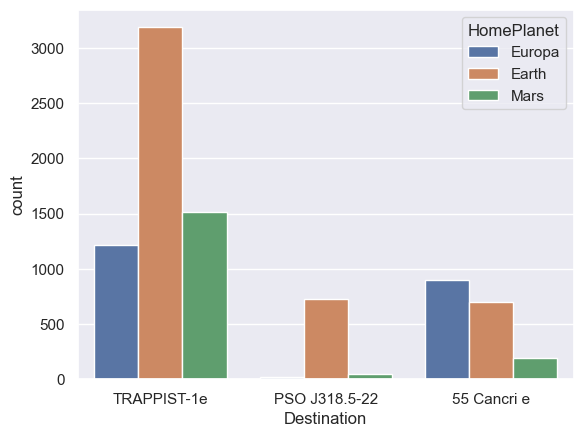

In [149]:
sns.countplot(x=train_data.Destination, hue=train_data.HomePlanet)
plt.show()

note:
- most of the passengers from Mars are travelling to TRAPPIST

action:
- replace missing values in destination with TRAPPIST, where planet is mars

In [157]:
home_planet_destination = train_data[['HomePlanet', 'Destination']]
home_planet_destination.head()

,HomePlanet,Destination
0,Europa,TRAPPIST-1e
1,Earth,TRAPPIST-1e
2,Europa,TRAPPIST-1e
3,Europa,TRAPPIST-1e
4,Earth,TRAPPIST-1e


In [158]:
home_planet_destination.isna().sum()

HomePlanet       0
Destination    182
dtype: int64

In [159]:
def fill_dest_with_hp(x):
    if x.HomePlanet == 'Mars' and pd.isna(x.Destination):
        k = x.copy()
        k.Destination = 'TRAPPIST-1e'
        return k
    else:
        return x

In [161]:
home_planet_destination_2 = home_planet_destination.apply(lambda x: fill_dest_with_hp(x), axis=1)

home_planet_destination_2.head()

,HomePlanet,Destination
0,Europa,TRAPPIST-1e
1,Earth,TRAPPIST-1e
2,Europa,TRAPPIST-1e
3,Europa,TRAPPIST-1e
4,Earth,TRAPPIST-1e


In [163]:
home_planet_destination_2.isna().sum()

HomePlanet       0
Destination    140
dtype: int64

In [166]:
# filling remaining values with mode
home_planet_destination_2.Destination.fillna('TRAPPIST-1e', inplace=True)

In [171]:
train_data.Destination = home_planet_destination_2.Destination

In [172]:
train_data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<br>

cryo sleep

In [174]:
deck = train_data.Cabin.apply(lambda x: np.nan if pd.isna(x) else x.split("/")[0])
num_in_cabin = train_data.Cabin.apply(lambda x: np.nan if pd.isna(x) else int(x.split("/")[1]))
side = train_data.Cabin.apply(lambda x: np.nan if pd.isna(x) else x.split("/")[2])

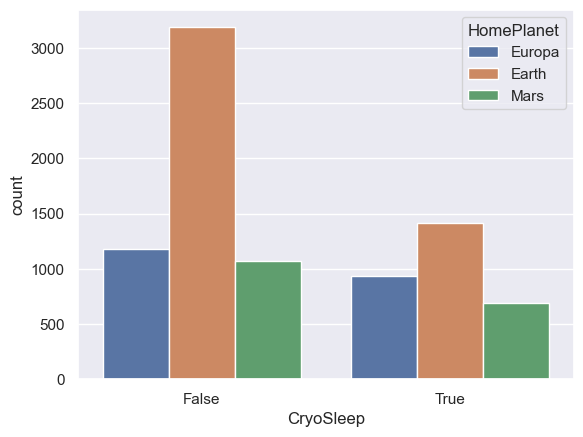

In [173]:
sns.countplot(x=train_data.CryoSleep, hue=train_data.HomePlanet)
plt.show()

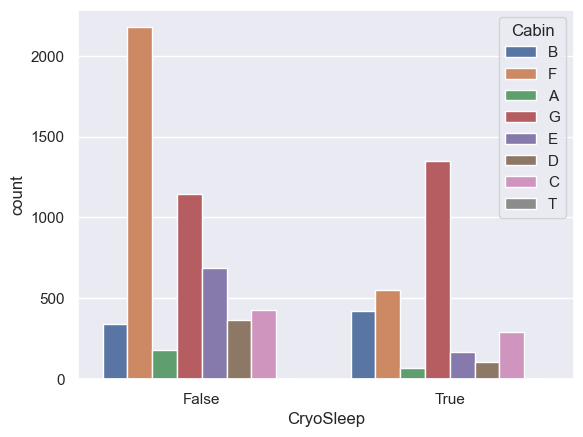

In [176]:
sns.countplot(x=train_data.CryoSleep, hue=deck)
plt.show()

note:
- more passengers in deck G are in cryosleep

action:
- replace missing values in cryo sleep with True, where deck is G
- otherwise fill with False